In [124]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import math
from math import radians, cos, sin, asin, sqrt
import sys
import matplotlib.pyplot as plt
import time, datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, f1_score  

In [23]:
# a

In [2]:
# 左下角经纬度坐标
lb_lon = 121.20120490000001
lb_lat = 31.28175691

# 上角经纬度坐标
rt_lon = 121.2183295
rt_lat = 31.29339344

# 栅格边长（左下角栅格坐标为 (0, 0) ）
grid_len = 20

In [3]:
# 根据两点经纬度计算两点间距离
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）  
    """ 
    Calculate the great circle distance between two points  
    on the earth (specified in decimal degrees) 
    """  
    # 将十进制度数转化为弧度  
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])  
  
    # haversine公式  
    dlon = lon2 - lon1   
    dlat = lat2 - lat1   
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2  
    c = 2 * asin(sqrt(a))   
    r = 6371 # 地球平均半径，单位为公里  
    return c * r * 1000  

In [4]:
# 横向最大距离
max_distance_x =  haversine(lb_lon, lb_lat, rt_lon, lb_lat)
# 右上角栅格横坐标
int(max_distance_x / 20)

81

In [5]:
# 纵向最大距离
max_distance_y = haversine(lb_lon, lb_lat, lb_lon, rt_lat)
# 右上角栅格纵坐标
int(max_distance_y / 20)

64

In [6]:
# 将地图栅格化，将经纬度坐标转化为栅格坐标，左下角的栅格坐标是 (0, 0) ，右上角的栅格坐标是 (81, 64)
# 再将栅格坐标转化为栅格ID（0 ～ 82 * 65 - 1 = 5329）共 5330 个栅格，左下角的栅格ID是 0 ，右上角的栅格ID是 5329
def ll_to_gridID(lon, lat):
    # 左下角经纬度坐标，栅格边长
    global lb_lon, lb_lat, grid_len
    
    # 将经纬度坐标转化为栅格坐标
    X = int(haversine(lon, lb_lat, lb_lon, lb_lat) / grid_len) 
    Y = int(haversine(lb_lon, lat, lb_lon, lb_lat) / grid_len)
    
    # 将栅格坐标转化为栅格ID：gridID = X + Y * 82
    gridID = X + Y * 82
    
    return (gridID)

In [7]:
# 将栅格ID转化为栅格中心经纬度
def gridID_to_ll(gridID):
    # 左下角经纬度坐标，右上角经纬度坐标，栅格边长
    global lb_lon, lb_lat, rt_lon, rt_lat
    
    # 将栅格ID转化为栅格坐标
    X = gridID % 82
    Y = int(gridID / 82)
    
    # 将栅格坐标转化为经纬度坐标
    # 栅格的边和栅格的中心位置将横向长度划分为 82 * 2 = 164 份
    # 栅格的边和栅格的中心位置将纵向长度划分为 65 * 2 = 130 份
    # 每一份的经度差：
    delta_lon = (rt_lon - lb_lon) / 164
    # 每一份的纬度差：
    delta_lat = (rt_lat - lb_lat) / 130
    # 栅格坐标横坐标为X的栅格的中心点经度：
    lon = lb_lon + (1 + 2 * X) * delta_lon
    # 栅格坐标纵坐标为Y的栅格的中心点经度：
    lat = lb_lat + (1 + 2 * Y) * delta_lat
    
    return [lon, lat]

In [8]:
# 合并两张表，用 data_2g 中的 RNCID_1，CellID_1 与 gongcan_2g 的 RNCID，CellID 匹配，将基站的经纬度信息加到 data_2g 中
def merge_data_gongcan():
    data_2g = pd.read_csv('../raw_data/data_2g.csv')
    gongcan_2g = pd.read_csv('../raw_data/2g_gongcan.csv')
    
    for i in range(1, 8):
        # 换掉 gongcan_2g 的列名用以和 data_2g merge
        gongcan_2g.columns = ['RNCID_' + str(i), 'CellID_' + str(i), 'Lat_' + str(i), 'Lon_' + str(i)]    
        data_2g = pd.merge(data_2g, gongcan_2g, how='left', on=['RNCID_' + str(i), 'CellID_' + str(i)])
        
    # 将 RSSI_1 ~ RSSI_7 的空缺值nan用 -sys.maxsize - 1 来代替
    for j in range(1, 8):
        data_2g['RSSI_' + str(j)] = data_2g['RSSI_' + str(j)].fillna(-sys.maxsize - 1)
    
    # 将其余空缺值nan替换为-1
    data_2g = data_2g.fillna(-1)
    return data_2g

In [9]:
# 根据MR数据的GPS加上栅格ID
def add_gridID(data):
    data['GridID'] = data.apply(lambda x: ll_to_gridID(x.Longitude, x.Latitude), axis = 1)
    return data

In [10]:
# 随机选取80%的数据记录作为训练集，余下20%作为测试集合
def data_train_test_split(data, random_seed):
    # 样本特征集（将 DataFrame 转化为 list）
    # 选取的特征包括 有效连接的基站数，7个基站的经纬度及相应的RSSI值 共22个特征
    X = data[['Lon_1', 'Lat_1', 'RSSI_1', 
              'Lon_2', 'Lat_2', 'RSSI_2', 
              'Lon_3', 'Lat_3', 'RSSI_3', 
              'Lon_4', 'Lat_4', 'RSSI_4',
              'Lon_5', 'Lat_5', 'RSSI_5',
              'Lon_6', 'Lat_6', 'RSSI_6',
              'Lon_7', 'Lat_7', 'RSSI_7',
              'Num_connected'
             ]].values
    # 样本结果（将 DataFrame 转化为 list ）
    y = data['GridID'].values
    
    # 随机选取80%的数据记录作为训练集，余下20%作为测试集合
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    
    return X_train, X_test, y_train, y_test

In [11]:
# 传入不同的分类器，训练并且作出预测
def train_classifier_and_predict(classifier_model, X_train, X_test, y_train):
    clf = classifier_model
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    return y_pred

In [12]:
# 计算预测位置和证实位置的误差（采用欧式距离），按照计算误差从小到大进行排序
# 返回小到大进行排序的误差
def calculate_error_and_sort(y_pred, y_test):
    
    # 将预测结果里的栅格ID转化为经纬度坐标
    y_pred = list(map(gridID_to_ll, y_pred))
    # 将测试结果里的栅格ID转化为经纬度坐标
    y_test = list(map(gridID_to_ll, y_test))
    
    # 将预测结果和测试结果的经纬度坐标放在同一个list里，形成一个二维数组
    temp = [y_pred[i] + y_test[i] for i in range(min(len(y_pred),len(y_test)))]
    
    # 计算各个误差
    errors = [haversine(x[0], x[1], x[2], x[3]) for x in temp]
    # 按照计算误差从小到大进行排序
    sorted_errors = sorted(errors)
    
    return sorted_errors

In [167]:
# 计算10次误差的平均值（即平均误差）
def calculate_avg_errors(errors_list):
    errors_avg = []
    for i in range(len(errors_list[0])):
        errors_avg.append(np.mean([x[i] for x in errors_list]))
    return  errors_avg

In [14]:
# 计算 precision，recall 和 f-measurement，对模型进行评价
def evaluate(y_pred, y_test):
    
    evaluations = {}
    
    # precision for each
    precision_foreach = precision_score(y_test, y_pred, average=None)
    evaluations['precision foreach'] = precision_foreach
    # precision overall
    precision_overall = precision_score(y_test, y_pred, average='macro')
    evaluations['precision overall'] = precision_overall
    # recall for each
    recall_foreach = recall_score(y_test, y_pred, average=None)
    evaluations['recall foreach'] = recall_foreach
    # recall overall
    recall_overall = recall_score(y_test, y_pred, average='macro')
    evaluations['recall overall'] = recall_overall
    # f-measurement for each
    f_measurement_foreach = f1_score(y_test, y_pred, average=None)
    evaluations['f-measurement foreach'] = f_measurement_foreach
    # f-measurement overall
    f_measurement_overall = f1_score(y_test, y_pred, average='macro')
    evaluations['f-measurement overall'] = f_measurement_overall
    
    return evaluations

In [15]:
## 调用前面的函数，传入分类器，返回10次预测结果和平均误差
def get_result(classifier_model, data):
    
    # 用以存储10次预测结果
    y_pred_list = []
    # 用以存储10次误差
    errors_list = []
    # 用以存储10次训练时间
    time_list = []
    
    for i in range(0, 10):
        # 随机选取80%的数据记录作为训练集，余下20%作为测试集合，传入i作为random_seed
        X_train, X_test, y_train, y_test = data_train_test_split(data, i)
        # 训练并且作出预测
        start = time.clock()
        y_pred = train_classifier_and_predict(classifier_model, X_train, X_test, y_train)
        end  = time.clock()
        delta_time = end - start
        time_list.append(delta_time)
        # 存储本次预测结果
        y_pred_list.append(list(y_pred))
        # 计算预测位置和证实位置的误差（采用欧式距离），按照计算误差从小到大进行排序
        errors = calculate_error_and_sort(y_pred, y_test)
        # 存储本次误差排序
        errors_list.append(errors)
        
    # 计算10次误差的平均值
    avg_errors = calculate_avg_errors(errors_list)
    
    # 找出0%, 10%，20%，30%，40%，50%，60%，70%，80%，90%，100%处的点
    lens = len(avg_errors)
    percents = np.arange(0.1, 1.1, 0.1)
    errors = []
    errors.append(avg_errors[0])
    for i in percents:
        errors.append(avg_errors[int(lens * i) - 1])
    
    # 计算 precision，recall 和 f-measurement
    evaluations = evaluate(y_pred, y_test)
    
    # 计算平均时间
    avg_time = np.array(time_list).mean()
    
    # 返回10次预测结果，平均误差，评价指标和平均时间
    return y_pred_list, errors, evaluations, avg_time

In [16]:
# 绘制平均误差概率分布图
def error_plot(classifier_models, model_errors):
    plt.style.use('ggplot')
    markers = ['v', '^', 'o', '+', '*', 'D', 'p', 's', 'x']

    xticks = np.arange(0, 1.1, 0.1)
    plt.xticks(xticks)
    for clf_name, marker in zip(classifier_models.keys(), markers):
        plt.plot(xticks, model_errors[clf_name],
                 linestyle='--', marker=marker, alpha=0.8)

    plt.title('Comparison of Classifiers')
    plt.xlabel('CDF')
    plt.ylabel('Error (meters)')
    plt.legend(classifier_models.keys())
    plt.savefig('Error_of_Models.png')
    plt.show()

In [17]:
# 绘制 precision，recall 和 f-measurement 图
def evaluations_plot(classifier_models, model_evaluations):
    plt.style.use('ggplot')
    xticks = np.arange(len(classifier_models))
    plt.xticks(xticks, classifier_models.keys(), rotation=20)
    markers = ['v', '+', 'o']

    evaluations = []

    precision = []
    recall = []
    f_measurement = []
    for key0 in model_evaluations:
        for key1 in model_evaluations[key0]:
            if key1 == 'precision overall':
                precision.append(model_evaluations[key0][key1])
            elif key1 == 'recall overall':
                recall.append(model_evaluations[key0][key1])
            elif key1 == 'f-measurement overall':
                f_measurement.append(model_evaluations[key0][key1])
    evaluations = [precision, recall, f_measurement]

    for evaluation, marker in zip(evaluations, markers):
        plt.plot(xticks, evaluation,
                 linestyle='--', marker=marker, alpha=0.8)

    plt.title('Evaluation of Models')
    plt.xlabel('Model Names')
    plt.ylabel('Value')
    plt.legend(['precision overall', 'recall overall', 'f-measurement overall'])
    plt.savefig('Evaluation_of_Models.png')
    plt.show()

In [18]:
# 绘制时间图
def time_plot(classifier_models, model_times):
    plt.style.use('ggplot')
    xticks = np.arange(len(classifier_models))
    plt.xticks(xticks, classifier_models.keys(), rotation=20)
    plt.plot(xticks, list(model_times.values()), marker='o', linestyle='--', alpha=0.8)

    plt.title('Time of Models')
    plt.xlabel('Model Names')
    plt.ylabel('Time')
    plt.savefig('Time_of_Models.png')
    plt.show()

In [19]:
def a():
    # 合并两张表
    data = merge_data_gongcan()
    
    # 根据MR数据的GPS换算成栅格ID作为结果
    data = add_gridID(data)
    
    # 7个分类器
    classifier_models = {
        # 高斯朴素贝叶斯分类器 Gaussian Naive Bayes (GaussianNB)
        'GaussianNB': GaussianNB(),
        # K近邻分类器 KNeighborsClassifier
        'KNeighbors': KNeighborsClassifier(n_neighbors=2),
        # 决策树分类器 DecisionTreeClassifier
        'DecisionTree': tree.DecisionTreeClassifier(criterion='entropy', max_depth=50),
        # 随机森林 RandomForestClassifier
        'RandomForest': RandomForestClassifier(max_depth=3, n_estimators=45),
        # AdaBoost AdaBoostClassifier
        'AdaBoost': AdaBoostClassifier(n_estimators=150, learning_rate = 0.1),
        # Bagging meta-estimator（Bagging 元估计器）BaggingClassifier
        'Bagging': BaggingClassifier(n_estimators=40),
        # GBDT（梯度树提升）GradientBoostingClassifier
        'GradientBoosting': GradientBoostingClassifier(n_estimators=40, max_depth=10)
}
    
    # 用以存储10次真实结果
    y_test_list = []
    
    # 得到10次真实结果
    for i in range(0, 10):
        X_train, X_test, y_train, y_test = data_train_test_split(data, i)
        y_test_list.append(list(y_test))
     
    # 存储模型的10次预测结果
    model_preds = {}
    # 存储模型的10次平均误差
    model_errors = {}
    # 存储模型的评价
    model_evaluations = {}
    # 存储模型训练时间
    model_times = {}
    
    # 获得每种分类器的10次预测结果
    for key in classifier_models:
        y_pred_list, avg_errors, evaluations, avg_time = get_result(classifier_models[key], data)
        model_preds[key] = y_pred_list
        model_errors[key] = avg_errors
        model_evaluations[key] = evaluations
        model_times[key] = avg_time
    
    # 绘制平均误差概率分布图
    error_plot(classifier_models, model_errors)
    # 绘制 precision，recall 和 f-measurement 图
    evaluations_plot(classifier_models, model_evaluations)
    # 绘制时间图
    time_plot(classifier_models, model_times)
        
    return  y_test_list, model_preds, model_errors, model_evaluations, model_times

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with n

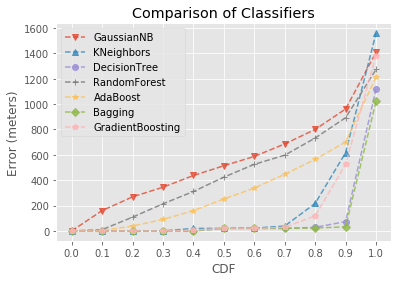

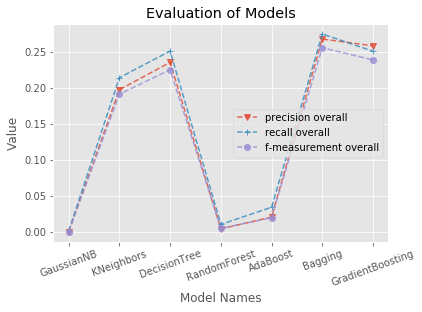

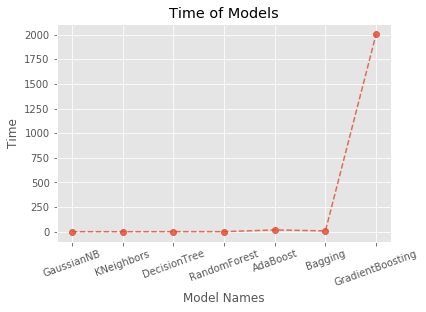

In [20]:
y_test_list, model_preds, model_errors, model_evaluations, model_times = a()

In [188]:
y_test_list

[[2846,
  5213,
  1925,
  3853,
  63,
  2352,
  4510,
  3133,
  3413,
  3495,
  2021,
  3336,
  3940,
  3328,
  5198,
  2681,
  1827,
  373,
  1609,
  2276,
  938,
  5208,
  1020,
  1873,
  5173,
  1746,
  1270,
  1512,
  4977,
  1753,
  892,
  4814,
  2269,
  1105,
  5176,
  3504,
  1609,
  2678,
  1281,
  5136,
  3824,
  2598,
  2929,
  3163,
  2919,
  53,
  4651,
  4382,
  4732,
  2681,
  3584,
  371,
  5176,
  371,
  2354,
  4651,
  4379,
  479,
  3417,
  4088,
  3510,
  2104,
  2677,
  1629,
  471,
  1179,
  3869,
  856,
  5139,
  1792,
  396,
  3417,
  2515,
  3328,
  1746,
  2275,
  4650,
  5204,
  4460,
  2597,
  1527,
  1342,
  57,
  4233,
  2966,
  3418,
  3328,
  4428,
  3094,
  5279,
  4390,
  5282,
  1691,
  1527,
  1711,
  3000,
  4366,
  2352,
  2352,
  2434,
  694,
  3493,
  3852,
  3417,
  1925,
  3080,
  5191,
  5208,
  1938,
  1341,
  3581,
  5175,
  230,
  5127,
  3778,
  3421,
  1827,
  396,
  4813,
  1191,
  1020,
  1022,
  2103,
  1018,
  726,
  3584,
  5217,
  3

In [186]:
model_preds

{'AdaBoost': [[2929,
   2275,
   3417,
   2275,
   938,
   3417,
   2231,
   1021,
   4731,
   3495,
   1780,
   3418,
   2474,
   3989,
   2231,
   2929,
   1021,
   3417,
   4813,
   3417,
   938,
   2231,
   1021,
   1792,
   2150,
   938,
   3417,
   3421,
   4813,
   938,
   1792,
   4813,
   2352,
   1278,
   2231,
   3422,
   4007,
   3081,
   1780,
   5137,
   3907,
   2929,
   2929,
   3417,
   3081,
   2599,
   2929,
   2150,
   4731,
   2929,
   3584,
   372,
   2231,
   372,
   2194,
   2929,
   3907,
   64,
   3417,
   4081,
   2929,
   1188,
   2759,
   1711,
   3417,
   938,
   2150,
   2599,
   3421,
   4081,
   1855,
   3417,
   2352,
   3907,
   1746,
   2275,
   4731,
   2231,
   2150,
   3081,
   4813,
   1422,
   938,
   2275,
   2231,
   4731,
   2759,
   2474,
   2929,
   2231,
   3907,
   2231,
   2352,
   3417,
   1855,
   3081,
   1020,
   3417,
   3417,
   2352,
   938,
   3417,
   2275,
   3417,
   3417,
   3080,
   2231,
   5129,
   1780,
   2599,
   3421,


In [38]:
 model_times

{'AdaBoost': 17.965240399999992,
 'Bagging': 7.9605032000000051,
 'DecisionTree': 0.27994979999999992,
 'GaussianNB': 0.1829975000000002,
 'GradientBoosting': 2006.8953565999996,
 'KNeighbors': 0.072133200000000119,
 'RandomForest': 0.40618760000000015}

In [187]:
model_evaluations

{'AdaBoost': {'f-measurement foreach': array([ 0.        ,  0.        ,  0.        ,  0.28571429,  0.22222222,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.36363636,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.15384615,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
 

In [39]:
model_errors

{'AdaBoost': [0.0,
  3.9688038220113433,
  38.376087250693686,
  90.168377325757746,
  159.75760188997495,
  251.88868094401977,
  337.57029195373622,
  446.89019644359598,
  563.56425277040967,
  702.06625120555782,
  1213.2955196202734],
 'Bagging': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  19.843348342885051,
  19.844870744227052,
  19.906509226702006,
  23.18695495456209,
  31.583005091606459,
  1021.7176366828132],
 'DecisionTree': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  19.84384956376325,
  19.870013681087997,
  19.906509226984937,
  28.108498809364058,
  73.465781056176382,
  1118.536267232334],
 'GaussianNB': [0.0,
  160.12369432994623,
  268.43777793750007,
  344.63992316319184,
  436.95648557159655,
  513.70055310372686,
  587.07746372002953,
  685.74681352703533,
  799.90918094653739,
  961.0400542054125,
  1407.9236631978783],
 'GradientBoosting': [0.0,
  0.0,
  0.0,
  0.0,
  5.9529928196095527,
  19.844882042276282,
  19.906509226702006,
  28.108355153594761,
  118.85225056568936,
 

In [21]:
# b

In [81]:
# 用以计算速度区间
def calculte_vs():
    
     # 合并两张表
    data = merge_data_gongcan()
    
    # 根据MR数据的GPS换算成栅格ID作为结果
    data = add_gridID(data)
    
    # 数据中IMSI只有 460012796993062，460011670515939，460016291512177 三个值，将他们分开
    ID1 = 460012796993062.00,
    ID2 = 460011670515939.06,
    ID3 = 460016291512176.94
    data_1 = data[data['IMSI'] == ID1].sort_values(by='MRTime')  
    data = data[data['IMSI'] == ID2].sort_values(by='MRTime')  
    data_3 = data[data['IMSI'] == ID3].sort_values(by='MRTime')  
    
    data = data.reset_index(drop=True)
    # 用以计算速度
    def calculte_v(a):
        return a[0] / a[1]
    # 计算出两行间的时间差和距离
    time = []
    dis = []
    for i in range(len(data_2) - 1):
        time.append((data_2.MRTime[i + 1] - data_2.MRTime[i]) / 1000)
        dis.append(haversine(data_2.Longitude[i], data_2.Latitude[i], data_2.Longitude[i + 1], data_2.Latitude[i + 1]))
    v = map(calculte_v, zip(dis, time))
    v_list = list(v)
    v_list.sort(reverse=True)
    return v_list

In [82]:
v_list = calculte_vs()

In [83]:
v_list

[515.81981738524985,
 391.41013961850666,
 224.04857415011094,
 58.943033630206031,
 57.498688933251934,
 54.795408089428719,
 53.667963706782849,
 47.890985689896048,
 47.709618159892415,
 46.127326396578951,
 41.488504128456256,
 40.962634704445456,
 40.222063774668726,
 33.374807675350006,
 32.857053586917033,
 32.427773094561601,
 31.922685719812957,
 31.735717666877473,
 31.473712568183874,
 31.234342197687976,
 30.981470297804481,
 30.453206335850425,
 30.04244460394176,
 29.574772560299582,
 29.469804546794453,
 29.416272564944038,
 28.448292267096026,
 27.264744841121423,
 26.644593938969066,
 26.282155357191517,
 26.139791019123479,
 26.07702827115158,
 25.918358817997831,
 25.917004336829972,
 25.88419991421085,
 25.76288754384079,
 25.704419926166967,
 25.498111418914263,
 25.399601570004709,
 25.396885351570702,
 25.230002343149319,
 24.989276660185926,
 24.600453583268269,
 24.584109700488543,
 24.199498946184413,
 23.958322547461453,
 23.68114581417349,
 23.65490677723454

In [50]:
def b():
    # 合并两张表
    data = merge_data_gongcan()
    
    # 根据MR数据的GPS换算成栅格ID作为结果
    data = add_gridID(data)
    
    # 数据中IMSI只有 460012796993062，460011670515939，460016291512177 三个值，将他们分开
    ID1 = 460012796993062.00,
    ID2 = 460011670515939.06,
    ID3 = 460016291512176.94
    data_1 = data[data['IMSI'] == ID1].sort_values(by='MRTime')  
    data_2 = data[data['IMSI'] == ID2].sort_values(by='MRTime')  
    data_3 = data[data['IMSI'] == ID3].sort_values(by='MRTime')  
    
    # 选择 60m/s 作为最高速度
    # 当速度大于 60m/s 时，认为点已经偏离
    # 选择 data_2 
    
    # 
    
    
    return data_2

In [24]:
# c

In [158]:
# 随机选取80%的数据记录作为训练集，余下20%作为测试集合
def data_train_test_split_c(data, label_name, random_seed):
    # 样本特征集（将 DataFrame 转化为 list）
    # 选取的特征包括 有效连接的基站数，7个基站的经纬度及相应的RSSI值 共22个特征
    X = data[['Lon_1', 'Lat_1', 'RSSI_1', 
              'Lon_2', 'Lat_2', 'RSSI_2', 
              'Lon_3', 'Lat_3', 'RSSI_3', 
              'Lon_4', 'Lat_4', 'RSSI_4',
              'Lon_5', 'Lat_5', 'RSSI_5',
              'Lon_6', 'Lat_6', 'RSSI_6',
              'Lon_7', 'Lat_7', 'RSSI_7',
              'Num_connected'
             ]].values
    # 样本结果（将 DataFrame 转化为 list ）
    y = data[label_name].values
    
    # 随机选取80%的数据记录作为训练集，余下20%作为测试集合，设置 random 状态使得每次 random 结果都一样
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_seed)
    
    return X_train, X_test, y_train, y_test

In [159]:
def calculate_error_and_sort_c(y_pred_lon, y_pred_lat, y_test_lon, y_test_lat, base_lon, base_lat):
    
    # 计算出预测的绝对经纬度
    pred_lon = [base_lon + x for x in y_pred_lon]
    pred_lat = [base_lat + x for x in y_pred_lat]
    # 计算出测试的绝对经纬度
    test_lon = [base_lon + x for x in y_test_lon]
    test_lat = [base_lat + x for x in y_test_lat]
    
    # 将预测结果和测试结果的经纬度坐标放在同一个list里，形成一个二维数组
    temp = [[pred_lon[i], pred_lat[i], test_lon[i], test_lat[i]] for i in range(len(pred_lon))]
    
    # 计算各个误差
    errors = [haversine(x[0], x[1], x[2], x[3]) for x in temp]    
    # 按照计算误差从小到大进行排序
    sorted_errors = sorted(errors)
    
    return sorted_errors

In [160]:
## 调用前面的函数，传入分类器，返回10次预测结果和平均误差
def get_result_c(data, base_lon, base_lat):
    
    # 用以存储10次预测结果
    y_pred_list = []
    # 用以存储10次误差
    errors_list = []
    # 用以存储10次训练时间
    time_list = []
    
    for i in range(0, 10):
        # 随机选取80%的数据记录作为训练集，余下20%作为测试集合，label 为经度
        X_train, X_test, y_train_lon, y_test_lon = data_train_test_split_c(data, 'deltaLon', i)
        # 随机选取80%的数据记录作为训练集，余下20%作为测试集合，label 为纬度
        X_train, X_test, y_train_lat, y_test_lat = data_train_test_split_c(data, 'deltaLat', i)
        
        # 训练并且作出预测
        start = time.clock()
        # label 为经度
        y_pred_lon = train_classifier_and_predict(RandomForestRegressor(max_depth=10, n_estimators=100), X_train, X_test, y_train_lon)
        # label 为纬度
        y_pred_lat = train_classifier_and_predict(RandomForestRegressor(max_depth=10, n_estimators=100), X_train, X_test, y_train_lat)
        end  = time.clock()
        delta_time = end - start
        time_list.append(delta_time)
        # 存储本次预测结果
        y_pred_list.append(list(zip(y_pred_lon, y_pred_lat)))
        # 计算预测位置和证实位置的误差（采用欧式距离），按照计算误差从小到大进行排序
        errors = calculate_error_and_sort_c(y_pred_lon, y_pred_lat, y_test_lon, y_test_lat, base_lon, base_lat)
        # 存储本次误差排序
        errors_list.append(errors)
        
    # 计算10次误差的平均值
    avg_errors = calculate_avg_errors(errors_list)
    
    
    # 找出0%, 10%，20%，30%，40%，50%，60%，70%，80%，90%，100%处的点
    lens = len(avg_errors)
    percents = np.arange(0.1, 1.1, 0.1)
    errors = []
    errors.append(avg_errors[0])
    for i in percents:
        errors.append(avg_errors[int(lens * i) - 1])
        
    # 计算平均时间
    avg_time = np.array(time_list).mean()
    
    # 返回10次预测结果，平均误差和平均时间
    return y_pred_list, errors, avg_time, avg_errors

In [175]:
# 绘制平均误差概率分布图
def error_plot(errors):
    plt.style.use('ggplot')
    xticks = np.arange(0, 1.1, 0.1)
    plt.xticks(xticks)
    plt.plot(xticks, errors, marker='o', linestyle='--', alpha=0.8)
    
    plt.title('Error Probability Distribution')
    plt.xlabel('CDF')
    plt.ylabel('Error (meters)')
    plt.savefig('Error_probability_distribution_for_c.png')
    plt.show()

In [178]:
def c():
    # 合并两张表
    data = merge_data_gongcan()
    
    # 根据MR数据的GPS换算成栅格ID作为结果
    data = add_gridID(data)
    
    # 计算与主基站的相对位置
    data['deltaLon'] = data.apply(lambda x: x['Longitude'] - x['Lon_1'], axis=1)
    data['deltaLat'] = data.apply(lambda x: x['Latitude'] - x['Lat_1'], axis=1)
    
    # 按照主基站分组
    data_group = data.groupby(['RNCID_1', 'CellID_1', 'Lon_1', 'Lat_1']).groups 
    
    # 存储分组后的数据，key为（'RNCID_1', 'CellID_1'）
    data_groupByBase = {}
    for id in data_group:
        data_list = data[(data['RNCID_1'] == id[0]) & (data['CellID_1'] == id[1])].reset_index(drop=True)
        data_groupByBase[id] = data_list

    # 记录各组预测结果
    pred_dict = {}
    # 记录各组误差结果
    error_dict = {}
    error_list = []
    # 记录各组平均时间
    time_dict ={}
    
    # 对于每一个组计算
    for key in data_groupByBase:
        y_pred_list, errors, avg_time, avg_errors= get_result_c(data_groupByBase[key], key[2], key[3])
        pred_dict[key] = y_pred_list
        error_dict[key] = errors
        time_dict[key] = avg_time
        error_list += avg_errors
    
    # 找出所有组合起来后，0%, 10%，20%，30%，40%，50%，60%，70%，80%，90%，100%处的点
    error_list = sorted(error_list)
    lens = len(error_list)
    percents = np.arange(0.1, 1.1, 0.1)
    errors = []
    errors.append(error_list[0])
    for i in percents:
        errors.append(error_list[int(lens * i) - 1])
   
    print(errors)
    # 绘制平均误差概率分布图
    error_plot(errors)
    
    # 计算总时长
    total_time = 0
    for key in time_dict:
        total_time += time_dict[key]
        
    # 返回
    return errors, error_dict, time_dict, total_time

[0.0, 7.0862094613439197, 11.400155240109367, 16.480129586979359, 21.430959221803963, 26.804714930403417, 33.533023854104876, 42.140912378278628, 54.770764791974486, 83.341558948683542, 454.339503636622]


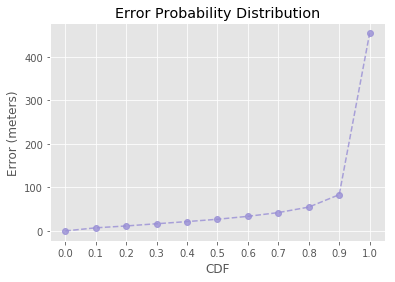

In [179]:
errors, error_dict, time_dict, total_time = c()

In [180]:
errors

[0.0,
 7.0862094613439197,
 11.400155240109367,
 16.480129586979359,
 21.430959221803963,
 26.804714930403417,
 33.533023854104876,
 42.140912378278628,
 54.770764791974486,
 83.341558948683542,
 454.339503636622]

In [182]:
error_dict

{(5198, 16058, 121.22063899999999, 31.281872999999997): [2.7864138869826087,
  7.3770887197867578,
  11.27205463267431,
  17.360719904581014,
  23.429321504559567,
  28.750914476936817,
  35.444697668324991,
  43.126996386800414,
  50.407951659190836,
  68.654079372923306,
  232.73287253903604],
 (5198, 16059, 121.209767, 31.284987): [6.2033674186640786,
  12.24569281523363,
  19.260592011277662,
  24.347199086263508,
  32.872361298674328,
  42.140912378278628,
  48.219982761825733,
  61.551725731337264,
  74.867766815809347,
  127.08764822302032,
  420.00686988371064],
 (5198, 17029, 121.22181599999999, 31.293837): [6.3768657060554288,
  8.1124719746256027,
  8.1124719746256027,
  8.1124719746256027,
  8.1124719746256027,
  6.3768657060554288,
  6.3768657060554288,
  6.3768657060554288,
  6.3768657060554288,
  6.3768657060554288,
  8.1124719746256027],
 (5198, 20608, 121.22107199999999, 31.257603000000003): [3.4926583358047147,
  5.9271416056200561,
  10.24899790862322,
  15.665547918

In [183]:
time_dict

{(5198, 16058, 121.22063899999999, 31.281872999999997): 0.30113689999961935,
 (5198, 16059, 121.209767, 31.284987): 0.21730620000089401,
 (5198, 17029, 121.22181599999999, 31.293837): 0.15717799999983981,
 (5198, 20608, 121.22107199999999, 31.257603000000003): 0.16995400000050723,
 (5198, 25312, 121.217402, 31.281802000000003): 0.22170340000011493,
 (5198, 36811, 121.21090900000002, 31.278470000000002): 0.15715860000018439,
 (5198, 38198, 121.206769, 31.28681): 0.16699630000039178,
 (6182, 13394, 121.19636499999999, 31.295884): 0.15711940000001051,
 (6182, 13666, 121.191709, 31.287846000000002): 0.15813140000100248,
 (6182, 13698, 121.191709, 31.287846000000002): 0.15779399999992166,
 (6182, 41139, 121.219323, 31.289351): 0.1692151000002923,
 (6182, 41233, 121.20615500000001, 31.294311999999998): 0.17570840000007593,
 (6182, 41235, 121.20615500000001, 31.294311999999998): 0.21763689999897906,
 (6182, 41503, 121.220505, 31.290893): 0.16378740000072867,
 (6182, 44771, 121.22292, 31.28719

In [148]:
time_dict

{(5198, 16058, 121.22063899999999, 31.281872999999997): 0.37881320000014967,
 (5198, 16059, 121.209767, 31.284987): 0.29188609999910115,
 (5198, 17029, 121.22181599999999, 31.293837): 0.22574530000019877,
 (5198, 20608, 121.22107199999999, 31.257603000000003): 0.22257979999994859,
 (5198, 25312, 121.217402, 31.281802000000003): 0.28600289999994855,
 (5198, 36811, 121.21090900000002, 31.278470000000002): 0.19169510000065201,
 (5198, 38198, 121.206769, 31.28681): 0.20475589999987279,
 (6182, 13394, 121.19636499999999, 31.295884): 0.19519529999961377,
 (6182, 13666, 121.191709, 31.287846000000002): 0.235675999999512,
 (6182, 13698, 121.191709, 31.287846000000002): 0.20491069999952743,
 (6182, 41139, 121.219323, 31.289351): 0.24686679999940681,
 (6182, 41233, 121.20615500000001, 31.294311999999998): 0.22679509999979927,
 (6182, 41235, 121.20615500000001, 31.294311999999998): 0.34415080000035231,
 (6182, 41503, 121.220505, 31.290893): 0.27427480000042126,
 (6182, 44771, 121.22292, 31.287198

In [184]:
total_time

7.9181518000044884